# CTG Fetal Health Prediction 

## 🏥 Problem Statement & Objective

**Problem Statement**: How can we build a solution that carefully interprets the patterns
hidden in a baby’s heart rate and the mother’s contractions, in order to automatically identify signs of fetal distress that might otherwise go unnoticed during labor? 

**Target**: NSP classification (Normal=1, Suspect=2, Pathological=3) using Cardiotocographic (CTG) measurements 

**Medical Importance**: Early detection of pathological cases can prevent fetal complications

**Challenge**: Only 8.3% pathological cases - severe class imbalance


#### Import Libraries and Load Data
Let's start by importing essential libraries and loading the data to see what we have.

#### Essential Libraries

Let us begin by importing the essential Python Libraries.

> NumPy : Library for Numeric Computations in Python  
> Pandas : Library for Data Acquisition and Preparation  
> Matplotlib : Low-level library for Data Visualization  
> Seaborn : Higher-level library for Data Visualization  

In [6]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt 

# Load the data
df = pd.read_excel('CTG.xls', sheet_name='Raw Data', header=0)
print(f"Shape: {df.shape}")

print("\nFirst few rows:")
df.head(10)

Shape: (2130, 40)

First few rows:


,FileName,Date,SegFile,b,e,LBE,LB,AC,FM,UC,...,C,D,E,AD,DE,LD,FS,SUSP,CLASS,NSP
0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Variab10.txt,1996-12-01,CTG0001.txt,240.0,357.0,120.0,120.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9.0,2.0
2,Fmcs_1.txt,1996-05-03,CTG0002.txt,5.0,632.0,132.0,132.0,4.0,0.0,4.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0
3,Fmcs_1.txt,1996-05-03,CTG0003.txt,177.0,779.0,133.0,133.0,2.0,0.0,5.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0
4,Fmcs_1.txt,1996-05-03,CTG0004.txt,411.0,1192.0,134.0,134.0,2.0,0.0,6.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0
5,Fmcs_1.txt,1996-05-03,CTG0005.txt,533.0,1147.0,132.0,132.0,4.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0
6,Fmcs_2.txt,1996-05-03,CTG0006.txt,0.0,953.0,134.0,134.0,1.0,0.0,10.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,8.0,3.0
7,Fmcs_2.txt,1996-05-03,CTG0007.txt,240.0,953.0,134.0,134.0,1.0,0.0,9.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,8.0,3.0
8,Hasc_1.txt,1995-02-22,CTG0008.txt,62.0,679.0,122.0,122.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9.0,3.0
9,Hasc_1.txt,1995-02-22,CTG0009.txt,120.0,779.0,122.0,122.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9.0,3.0


### Description of the dataset-CTG Features

**Exam Data:**
- `FileName`: CTG examination file name
- `Date`: Date of examination  
- `b`: Start instant (time)
- `e`: End instant (time)

**Baseline Measurements:**
- `LBE`: Baseline value (medical expert)
- `LB`: Baseline value (SisPorto system)

**Movement & Contractions:**
- `AC`: Accelerations (SisPorto)
- `FM`: Foetal movement (SisPorto) 
- `UC`: Uterine contractions (SisPorto)

**Variability Features:**
- `ASTV`: % time with abnormal short term variability
- `MSTV`: Mean value of short term variability (SisPorto)
- `ALTV`: % time with abnormal long term variability  
- `MLTV`: Mean value of long term variability (SisPorto)

**Decelerations:**
- `DL`: Light decelerations
- `DS`: Severe decelerations
- `DP`: Prolonged decelerations
- `DR`: Repetitive decelerations (removed since p(K-W)=1)

**Histogram Features:**
- `Width`: Histogram width
- `Min`: Low frequency of histogram
- `Max`: High frequency of histogram
- `Nmax`: Number of histogram peaks
- `Nzeros`: Number of histogram zeroUterine contractions
- `Mode`: Histogram mode
- `Mean`: Histogram mean
- `Median`: Histogram median
- `Variance`: Histogram variance
- `Tendency`: Histogram tendency (-1=left asymmetric; 0=symmetric; +1=right asymmetric)

**Fetal State Pattern Recognition:**
- `A`: Calm sleep
- `B`: REM sleep  
- `C`: Calm vigilance
- `D`: Active vigilance
- `E`: Shift pattern (A or Susp with shifts)
- `AD`: Accelerative/decelerative pattern (stress situations)
- `DE`: Decelerative pattern (vagal stimulation)
- `LD`: Largely decelerative pattern
- `FS`: Flat-sinusoidal pattern (pathological state)
- `SUSP`: Suspect pattern

**Target Variables:**
- `CLASS`: Class code (1-10) for detailed classification
- `NSP`: **Main Target** - Normal=1, Suspect=2, Pathological=3

In [9]:
df.describe()

,Date,b,e,LBE,LB,AC,FM,UC,ASTV,MSTV,...,C,D,E,AD,DE,LD,FS,SUSP,CLASS,NSP
count,2126,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2127.000000,2127.000000,2127.000000,2127.000000,...,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000
mean,1996-04-22 16:59:22.746942592,878.439793,1702.877234,133.303857,133.303857,2.722484,7.503056,3.669017,47.008933,1.335449,...,0.024929,0.038100,0.033866,0.156162,0.118532,0.050329,0.032455,0.092662,4.509878,1.304327
min,1980-01-04 00:00:00,0.000000,287.000000,106.000000,106.000000,0.000000,0.000000,0.000000,12.000000,0.200000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,1996-05-02 00:00:00,55.000000,1009.000000,126.000000,126.000000,0.000000,0.000000,1.000000,32.000000,0.700000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000
50%,1996-08-21 00:00:00,538.000000,1241.000000,133.000000,133.000000,1.000000,0.000000,3.000000,49.000000,1.200000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,1.000000
75%,1997-03-20 00:00:00,1521.000000,2434.750000,140.000000,140.000000,4.000000,2.000000,5.000000,61.000000,1.700000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,1.000000
max,1998-06-06 00:00:00,3296.000000,3599.000000,160.000000,160.000000,26.000000,564.000000,23.000000,87.000000,7.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,10.000000,3.000000
std,NaN,894.084748,930.919143,9.840844,9.840844,3.560850,39.030452,2.877148,17.210648,0.891543,...,0.155947,0.191482,0.180928,0.363094,0.323314,0.218675,0.177248,0.290027,3.026883,0.614377


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2130 entries, 0 to 2129
Data columns (total 40 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   FileName  2126 non-null   object        
 1   Date      2126 non-null   datetime64[ns]
 2   SegFile   2126 non-null   object        
 3   b         2126 non-null   float64       
 4   e         2126 non-null   float64       
 5   LBE       2126 non-null   float64       
 6   LB        2126 non-null   float64       
 7   AC        2126 non-null   float64       
 8   FM        2127 non-null   float64       
 9   UC        2127 non-null   float64       
 10  ASTV      2127 non-null   float64       
 11  MSTV      2127 non-null   float64       
 12  ALTV      2127 non-null   float64       
 13  MLTV      2127 non-null   float64       
 14  DL        2128 non-null   float64       
 15  DS        2128 non-null   float64       
 16  DP        2128 non-null   float64       
 17  DR        2128

## Preprocess & Clean the CTG Data

#### Checking Missing Values

In [15]:
print(df.isnull().sum())

FileName    4
Date        4
SegFile     4
b           4
e           4
LBE         4
LB          4
AC          4
FM          3
UC          3
ASTV        3
MSTV        3
ALTV        3
MLTV        3
DL          2
DS          2
DP          2
DR          2
Width       4
Min         4
Max         4
Nmax        4
Nzeros      4
Mode        4
Mean        4
Median      4
Variance    4
Tendency    4
A           4
B           4
C           4
D           4
E           4
AD          4
DE          4
LD          4
FS          4
SUSP        4
CLASS       4
NSP         4
dtype: int64


In [17]:
# Clean the data - remove empty first row
df_clean = df.dropna(subset=['NSP']).reset_index(drop=True)

In [19]:
df_clean.isnull().sum()

FileName    0
Date        0
SegFile     0
b           0
e           0
LBE         0
LB          0
AC          0
FM          0
UC          0
ASTV        0
MSTV        0
ALTV        0
MLTV        0
DL          0
DS          0
DP          0
DR          0
Width       0
Min         0
Max         0
Nmax        0
Nzeros      0
Mode        0
Mean        0
Median      0
Variance    0
Tendency    0
A           0
B           0
C           0
D           0
E           0
AD          0
DE          0
LD          0
FS          0
SUSP        0
CLASS       0
NSP         0
dtype: int64

In [21]:
print(f"\n=== Missing Values ===")
missing_counts = df_clean.isnull().sum()
missing_features = missing_counts[missing_counts > 0]
if len(missing_features) > 0:
    print("Features with missing values:")
    print(missing_features)
else:
    print("No missing values in cleaned data!")


=== Missing Values ===
No missing values in cleaned data!


#### Checking Duplicate Values

In [24]:
def find_duplicate_columns(df_clean):
    duplicates = []
    columns = df_clean.columns

    # Compare each pair of columns
    for i in range(len(columns)):
        for j in range(i+1, len(columns)):
            col1, col2 = columns[i], columns[j]
            # Check if the columns are identical in values
            if df_clean[col1].equals(df_clean[col2]):
                duplicates.append((col1, col2))
    
    return duplicates

# Call the function and print the result
duplicates = find_duplicate_columns(df_clean)
if duplicates:
    print("Duplicate columns found:")
    for col1, col2 in duplicates:
        print(f"Column '{col1}' is identical to column '{col2}'. Drop '{col2}'")
        df_clean.drop(col2, axis=1, inplace=True)
else:
    print("No duplicate columns found.")

Duplicate columns found:
Column 'LBE' is identical to column 'LB'. Drop 'LB'


#### Remove useless column(all zero column)

In [27]:
def remove_zero_columns(df):
    df_without_first_row = df.iloc[1:]
    
    zero_columns = df_without_first_row.columns[(df_without_first_row == 0).all()]
    
    # Drop these columns
    df.drop(columns=zero_columns, inplace=True)
    
    print(f"Removed columns with all zeros: {list(zero_columns)}")
    return df

df_cleaned = remove_zero_columns(df_clean)

Removed columns with all zeros: ['DR']


In [29]:
print(f"\n=== Data Types ===")
print(df_cleaned.dtypes.value_counts())


=== Data Types ===
float64           35
object             2
datetime64[ns]     1
Name: count, dtype: int64


In [31]:
df_cleaned.shape

(2126, 38)

In [33]:
df_cleaned.head()

,FileName,Date,SegFile,b,e,LBE,AC,FM,UC,ASTV,...,C,D,E,AD,DE,LD,FS,SUSP,CLASS,NSP
0,Variab10.txt,1996-12-01,CTG0001.txt,240.0,357.0,120.0,0.0,0.0,0.0,73.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9.0,2.0
1,Fmcs_1.txt,1996-05-03,CTG0002.txt,5.0,632.0,132.0,4.0,0.0,4.0,17.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0
2,Fmcs_1.txt,1996-05-03,CTG0003.txt,177.0,779.0,133.0,2.0,0.0,5.0,16.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0
3,Fmcs_1.txt,1996-05-03,CTG0004.txt,411.0,1192.0,134.0,2.0,0.0,6.0,16.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0
4,Fmcs_1.txt,1996-05-03,CTG0005.txt,533.0,1147.0,132.0,4.0,0.0,5.0,16.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0


#### Data Exploration

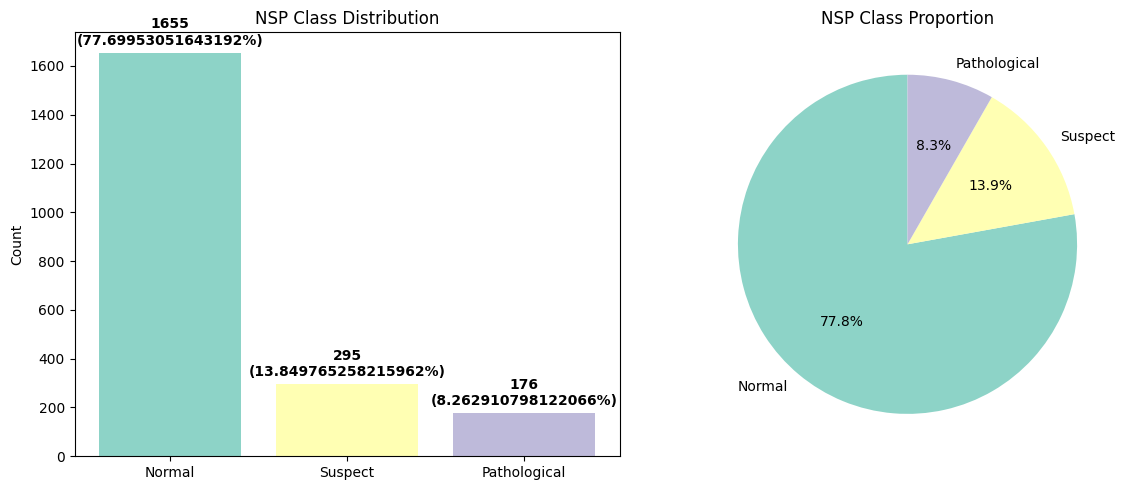

,Class,Count,Proportion
0,1,1655,1655
1,2,295,295
2,3,176,176


In [40]:
# Visualize target distribution
plt.figure(figsize=(12, 5))

nsp_counts = df_cleaned['NSP'].value_counts()
total_count = len(df)
nsp_percentages = (nsp_count / total_count) * 100

# Bar plot
plt.subplot(1, 2, 1)
colors = sb.color_palette("Set3")
bars = plt.bar(['Normal', 'Suspect', 'Pathological'], nsp_counts.values, color=colors)
plt.title('NSP Class Distribution')
plt.ylabel('Count')
for i, (bar, count, pct) in enumerate(zip(bars, nsp_counts.values, nsp_percentages)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20, 
             f'{count}\n({pct}%)', ha='center', va='bottom', fontweight='bold')

# Pie chart
plt.subplot(1, 2, 2)
plt.pie(nsp_counts.values, labels=['Normal', 'Suspect', 'Pathological'], 
        autopct='%1.1f%%', colors=colors, startangle=90)
plt.title('NSP Class Proportion')

plt.tight_layout()
plt.show()

#DataFrame
pd.DataFrame({
    'Class': nsp_counts.index.astype(int),
    'Count': nsp_counts.values,
    'Proportion': nsp_counts.values
})

In [38]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 38 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   FileName  2126 non-null   object        
 1   Date      2126 non-null   datetime64[ns]
 2   SegFile   2126 non-null   object        
 3   b         2126 non-null   float64       
 4   e         2126 non-null   float64       
 5   LBE       2126 non-null   float64       
 6   AC        2126 non-null   float64       
 7   FM        2126 non-null   float64       
 8   UC        2126 non-null   float64       
 9   ASTV      2126 non-null   float64       
 10  MSTV      2126 non-null   float64       
 11  ALTV      2126 non-null   float64       
 12  MLTV      2126 non-null   float64       
 13  DL        2126 non-null   float64       
 14  DS        2126 non-null   float64       
 15  DP        2126 non-null   float64       
 16  Width     2126 non-null   float64       
 17  Min       2126

In [52]:
df_cleaned.describe()

,Date,b,e,LBE,AC,FM,UC,ASTV,MSTV,ALTV,...,C,D,E,AD,DE,LD,FS,SUSP,CLASS,NSP
count,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.00000,...,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000
mean,35177.707902,878.439793,1702.877234,133.303857,2.722484,7.241298,3.659925,46.990122,1.332785,9.84666,...,0.024929,0.038100,0.033866,0.156162,0.118532,0.050329,0.032455,0.092662,4.509878,1.304327
std,1038.632386,894.084748,930.919143,9.840844,3.560850,37.125309,2.847094,17.192814,0.883241,18.39688,...,0.155947,0.191482,0.180928,0.363094,0.323314,0.218675,0.177248,0.290027,3.026883,0.614377
min,29224.000000,0.000000,287.000000,106.000000,0.000000,0.000000,0.000000,12.000000,0.200000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,35187.000000,55.000000,1009.000000,126.000000,0.000000,0.000000,1.000000,32.000000,0.700000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000
50%,35298.000000,538.000000,1241.000000,133.000000,1.000000,0.000000,3.000000,49.000000,1.200000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,1.000000
75%,35509.000000,1521.000000,2434.750000,140.000000,4.000000,2.000000,5.000000,61.000000,1.700000,11.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,1.000000
max,35952.000000,3296.000000,3599.000000,160.000000,26.000000,564.000000,23.000000,87.000000,7.000000,91.00000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,10.000000,3.000000


In [53]:
# Prepare features for analysis
print("=== Feature Preparation ===")
# Remove metadata columns 
X_features = df_clean.drop(['FileName', 'Date', 'SegFile', 'NSP', 'CLASS'], axis=1)
y_target = df_clean['NSP'].astype(int)

print(f"Features shape: {X_features.shape}")
print(f"Target shape: {y_target.shape}")

=== Feature Preparation ===
Features shape: (2126, 33)
Target shape: (2126,)


In [54]:
print(df_clean['NSP'].head(10))
print("dtype:", df_clean['NSP'].dtype)
print("NaN count:", df_clean['NSP'].isna().sum())
print("Unique (sample):", pd.Series(df_clean['NSP']).astype(str).unique()[:10])

0    2.0
1    1.0
2    1.0
3    1.0
4    1.0
5    3.0
6    3.0
7    3.0
8    3.0
9    3.0
Name: NSP, dtype: float64
dtype: float64
NaN count: 0
Unique (sample): ['2.0' '1.0' '3.0']


#### Feature Exploration

In [55]:
medical_features = df_cleaned[['LBE','AC','FM','UC','DL','DS','DP','ASTV','ALTV']]

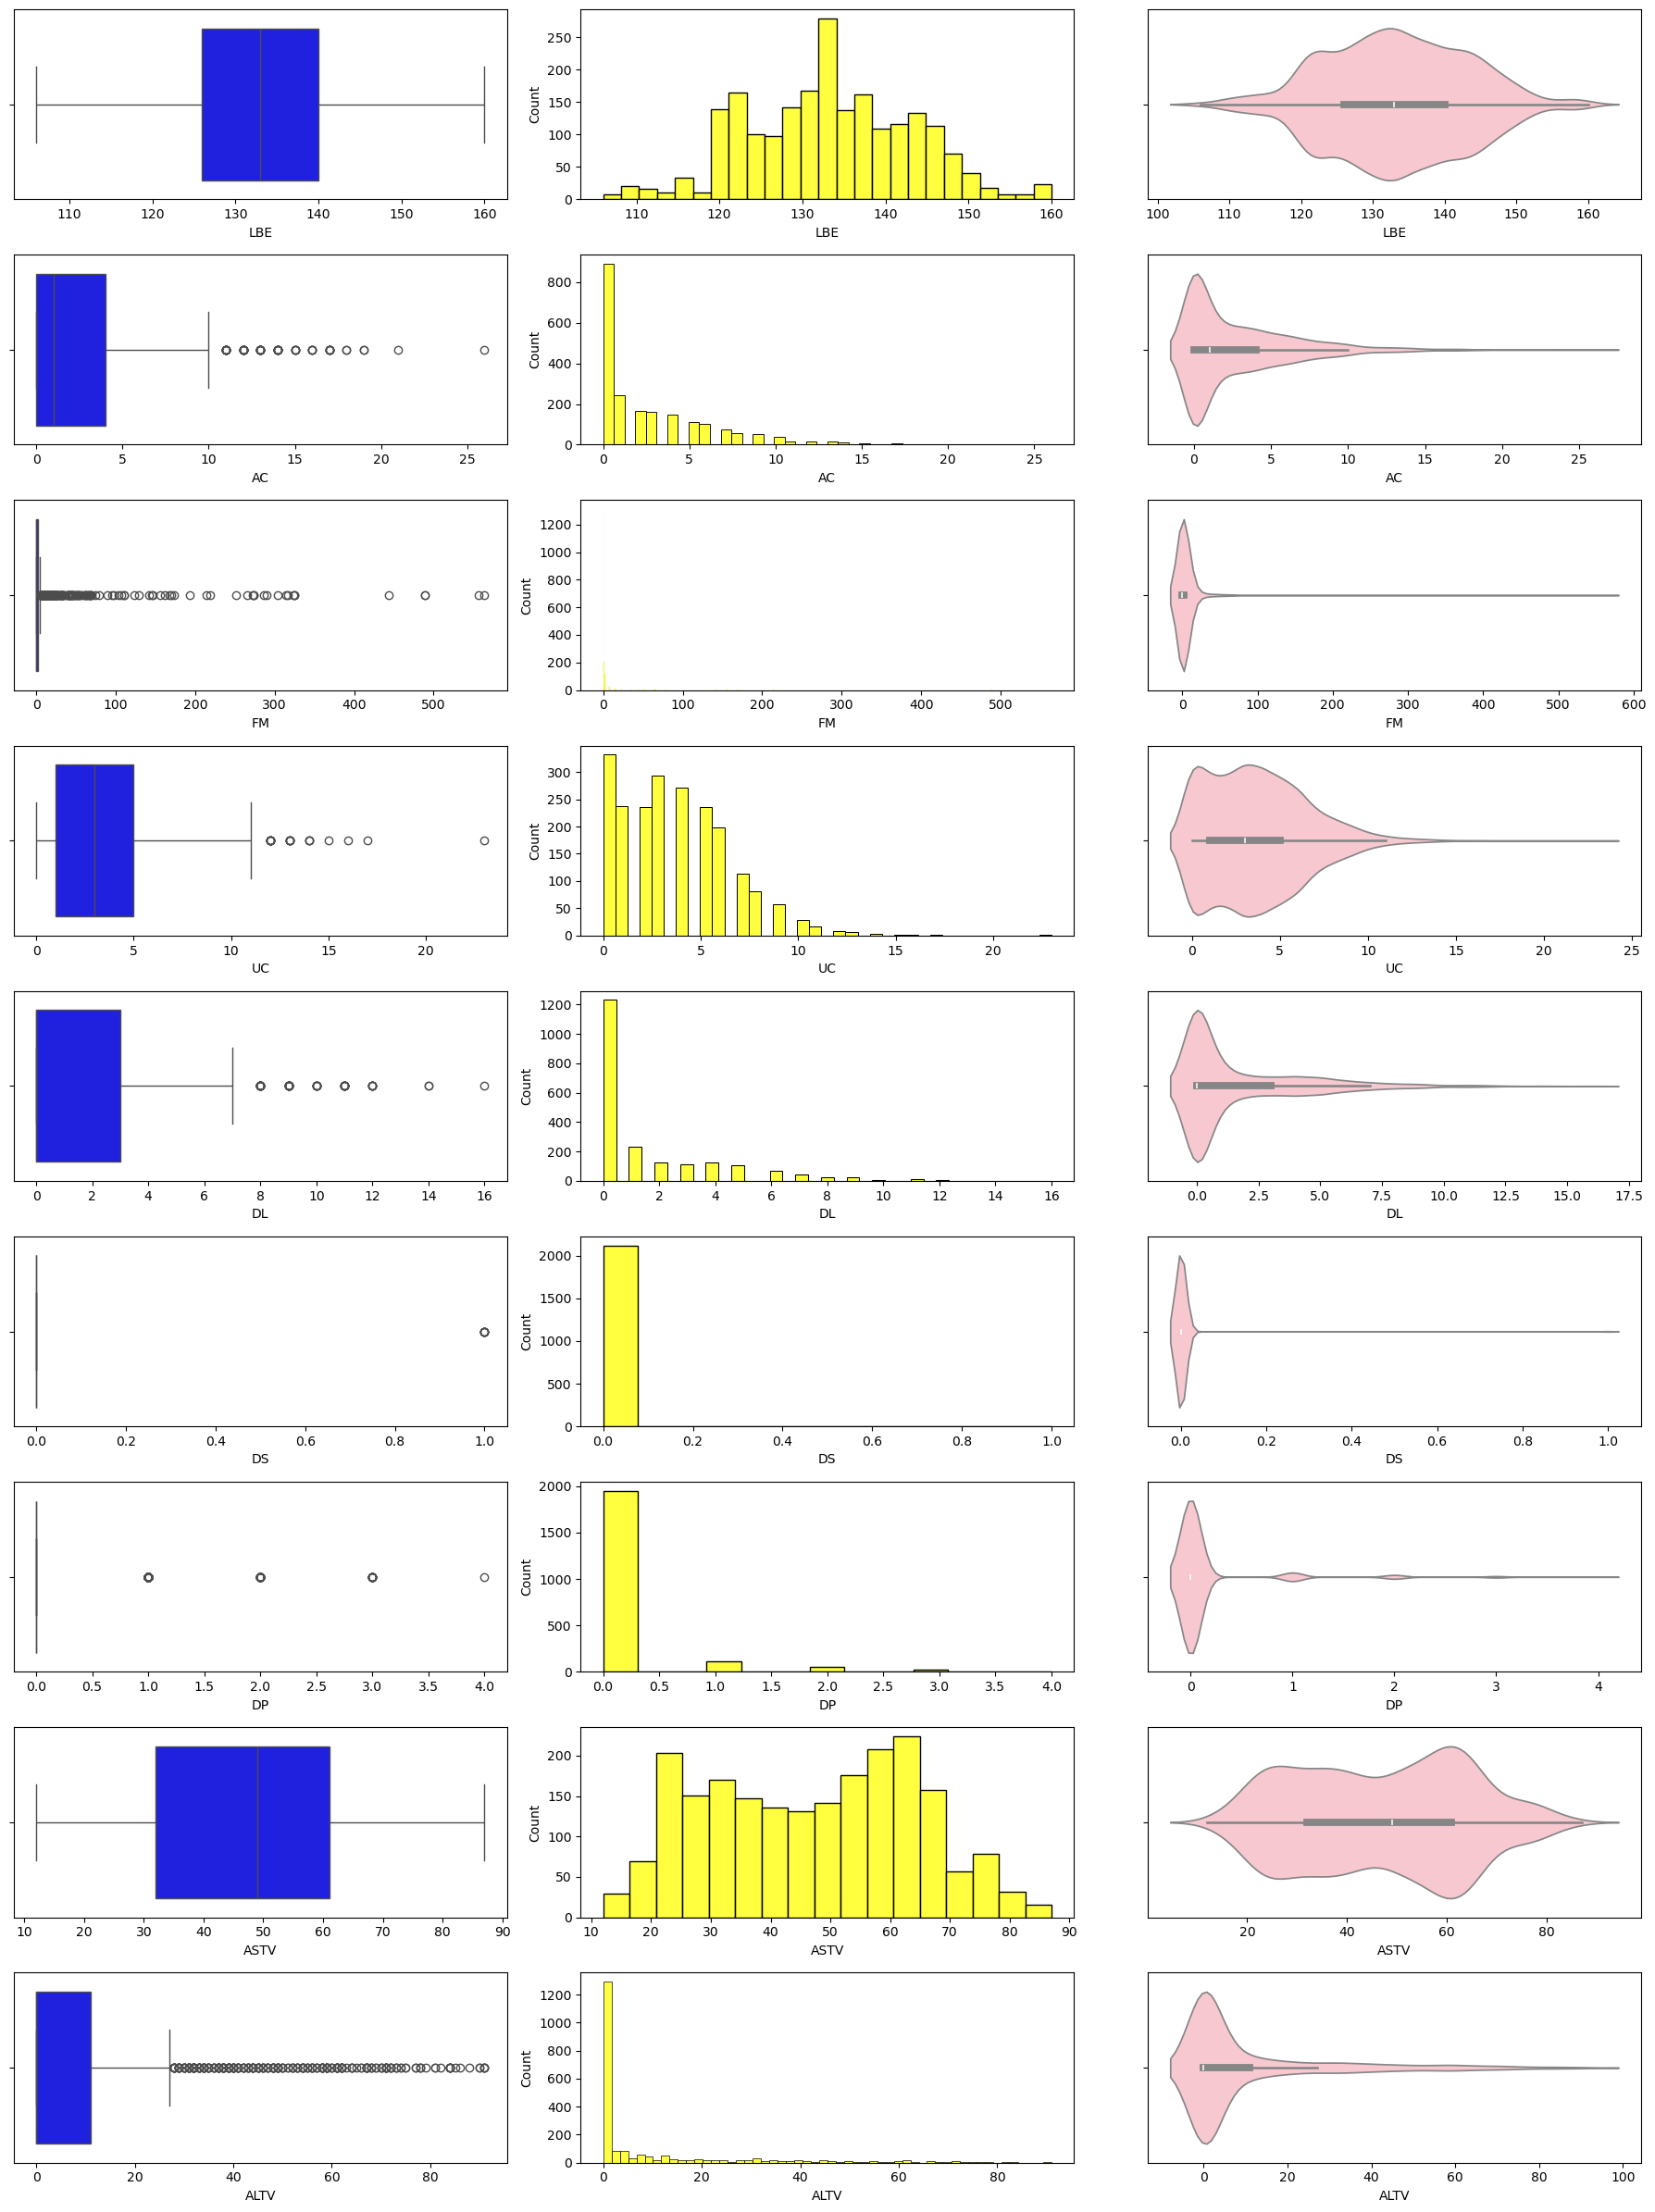

In [56]:
fig, axes = plt.subplots(9, 3, figsize=(18, 24))

count = 0
for var in medical_features:
    # Boxplot
    sb.boxplot(data=medical_features[var], orient="h", ax=axes[count, 0], color='blue')
    axes[count, 0].set_xlabel(var) 
    
    # Histogram
    sb.histplot(data=medical_features[var], ax=axes[count, 1], color='yellow')
    axes[count, 1].set_xlabel(var)  
    
    # Violin Plot
    sb.violinplot(data=medical_features[var], orient="h", ax=axes[count, 2], color='pink')
    axes[count, 2].set_xlabel(var) 
    
    count += 1

plt.tight_layout()  
plt.show()

<Axes: >

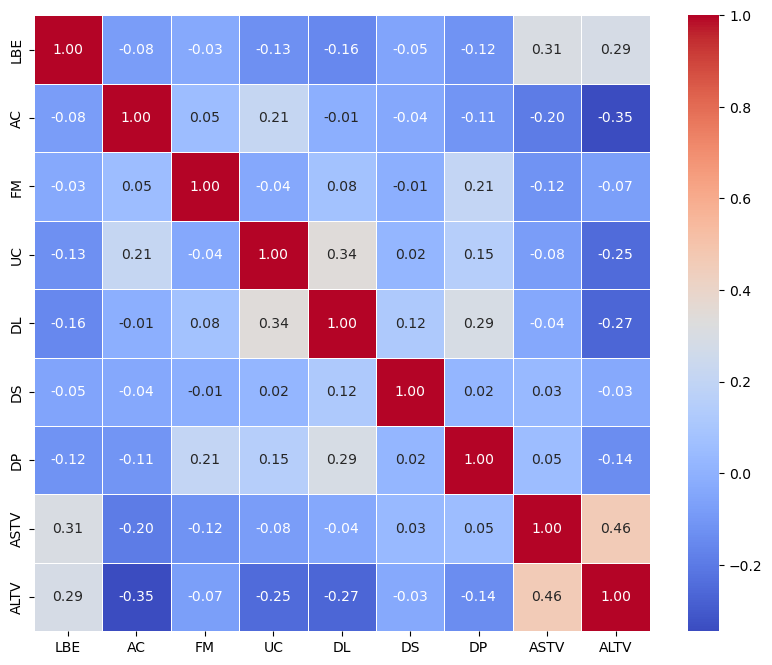

In [57]:
corr_matrix = medical_features.corr()

plt.figure(figsize=(10, 8))
sb.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True, square=True, linewidths=0.5)

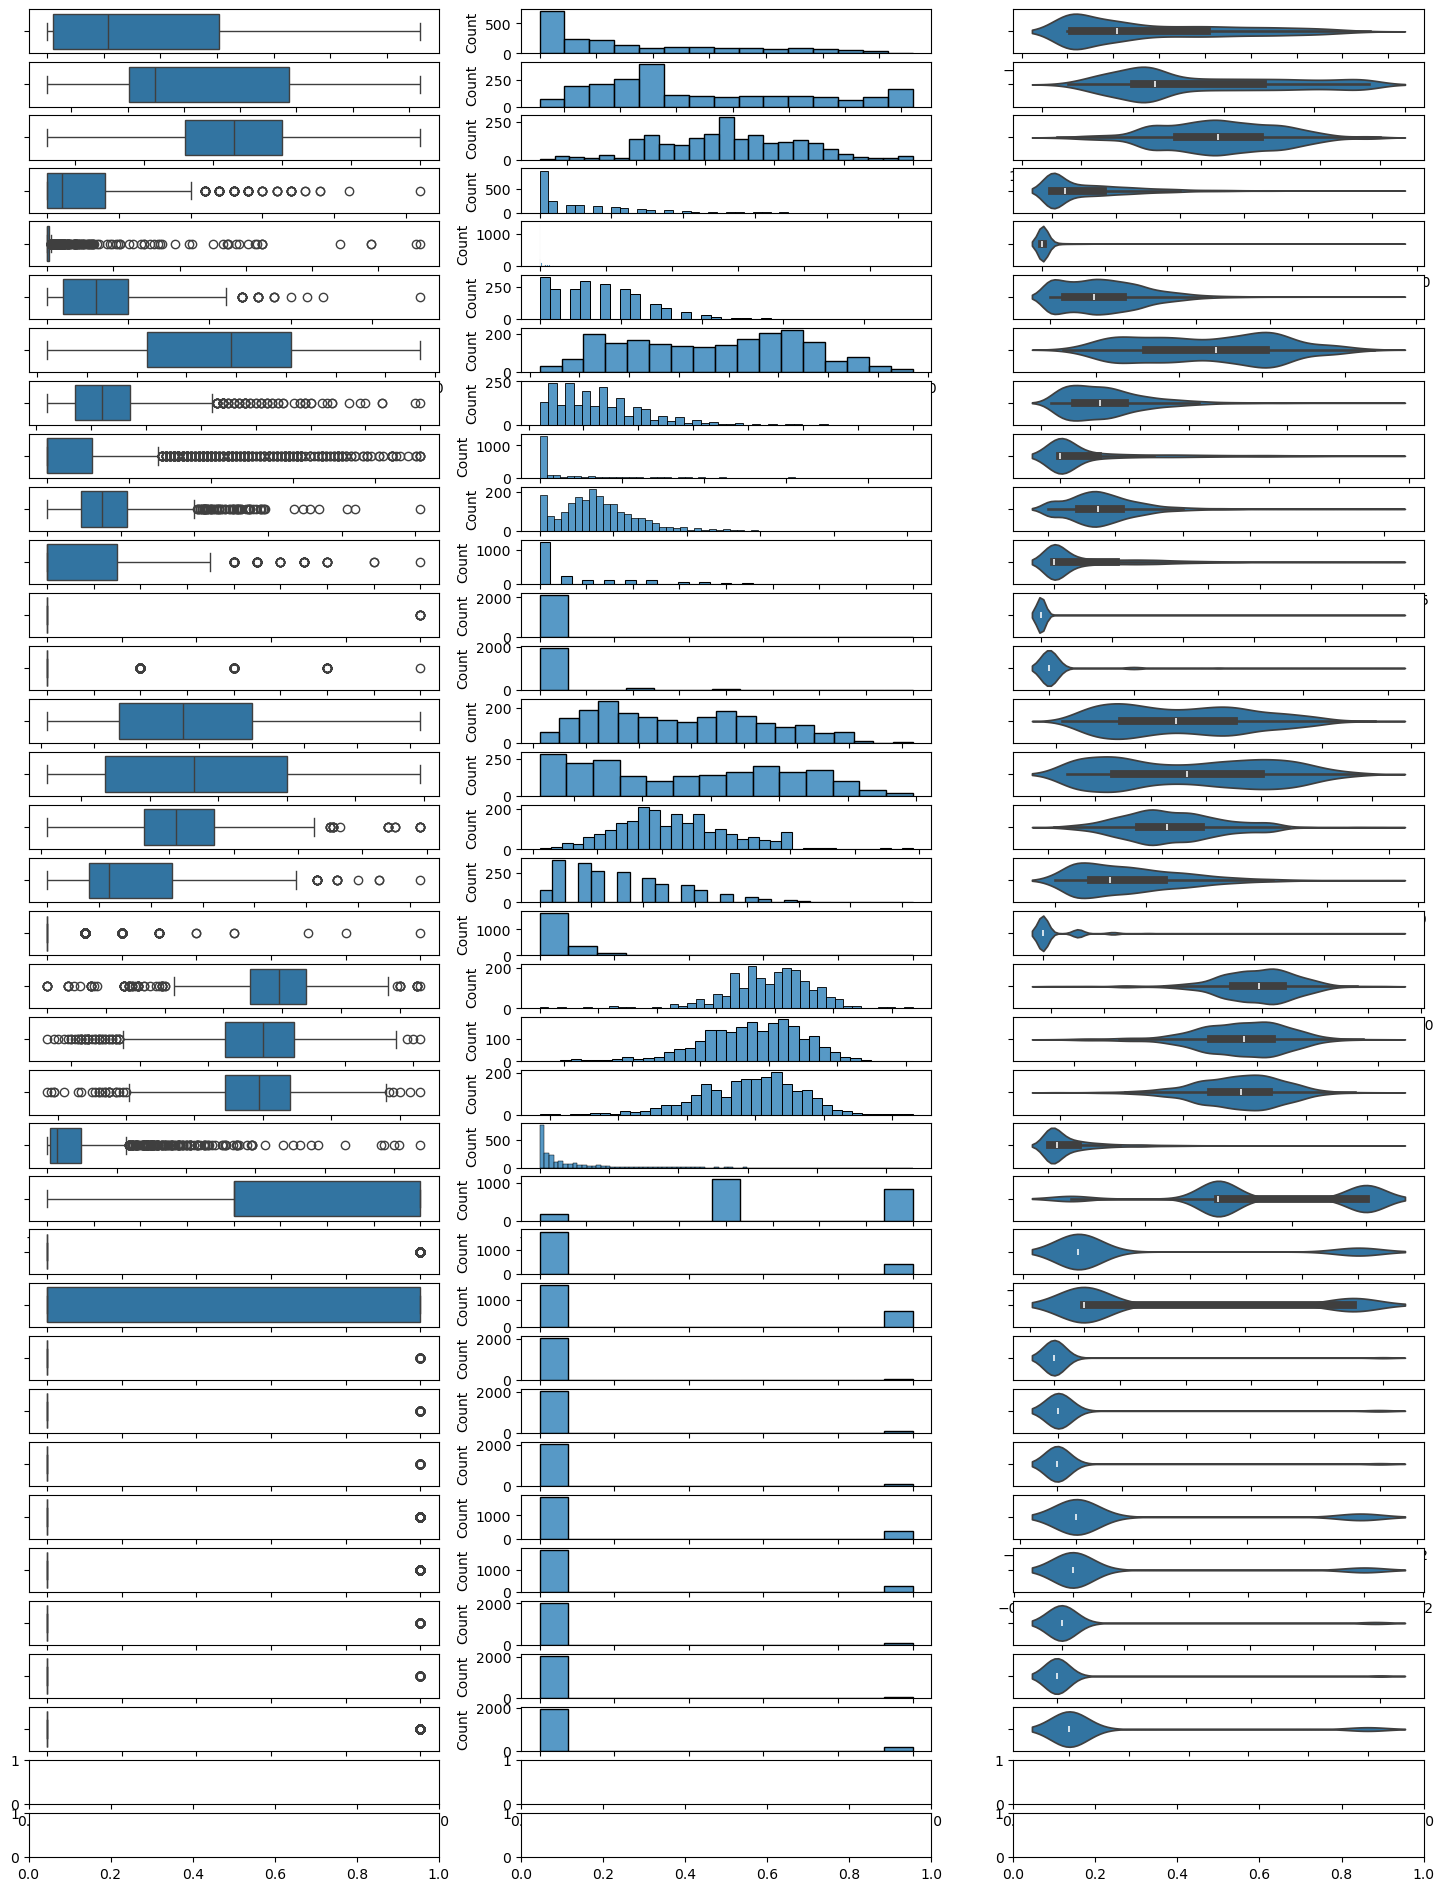

In [58]:
f, axes = plt.subplots(35, 3, figsize=(18, 24))

count = 0
for var in X_features:
    sb.boxplot(data = X_features[var], orient = "h", ax = axes[count,0])
    sb.histplot(data = X_features[var], ax = axes[count,1])
    sb.violinplot(data = X_features[var], orient = "h", ax = axes[count,2])
    count += 1

In [59]:
# Correlation Matrix
print(X_features.corr())

                 b         e       LBE        AC        FM        UC  \
b         1.000000  0.944912 -0.020400 -0.038359 -0.133849  0.225595   
e         0.944912  1.000000 -0.013979  0.071572 -0.119249  0.386856   
LBE      -0.020400 -0.013979  1.000000 -0.077967 -0.033305 -0.127722   
AC       -0.038359  0.071572 -0.077967  1.000000  0.053956  0.212100   
FM       -0.133849 -0.119249 -0.033305  0.053956  1.000000 -0.036626   
UC        0.225595  0.386856 -0.127722  0.212100 -0.036626  1.000000   
ASTV     -0.126355 -0.066374  0.305570 -0.197985 -0.116461 -0.079651   
MSTV      0.040505  0.044605 -0.279607  0.191378  0.138061  0.232687   
ALTV     -0.109861 -0.104566  0.285630 -0.345162 -0.072214 -0.247513   
MLTV     -0.100027 -0.108141 -0.032091 -0.128901  0.021031 -0.106590   
DL        0.091783  0.163257 -0.155908 -0.011350  0.076283  0.339484   
DS        0.063977  0.068221 -0.053518 -0.039341 -0.010328  0.018405   
DP        0.091688  0.111917 -0.117133 -0.110317  0.205337  0.15

<Axes: >

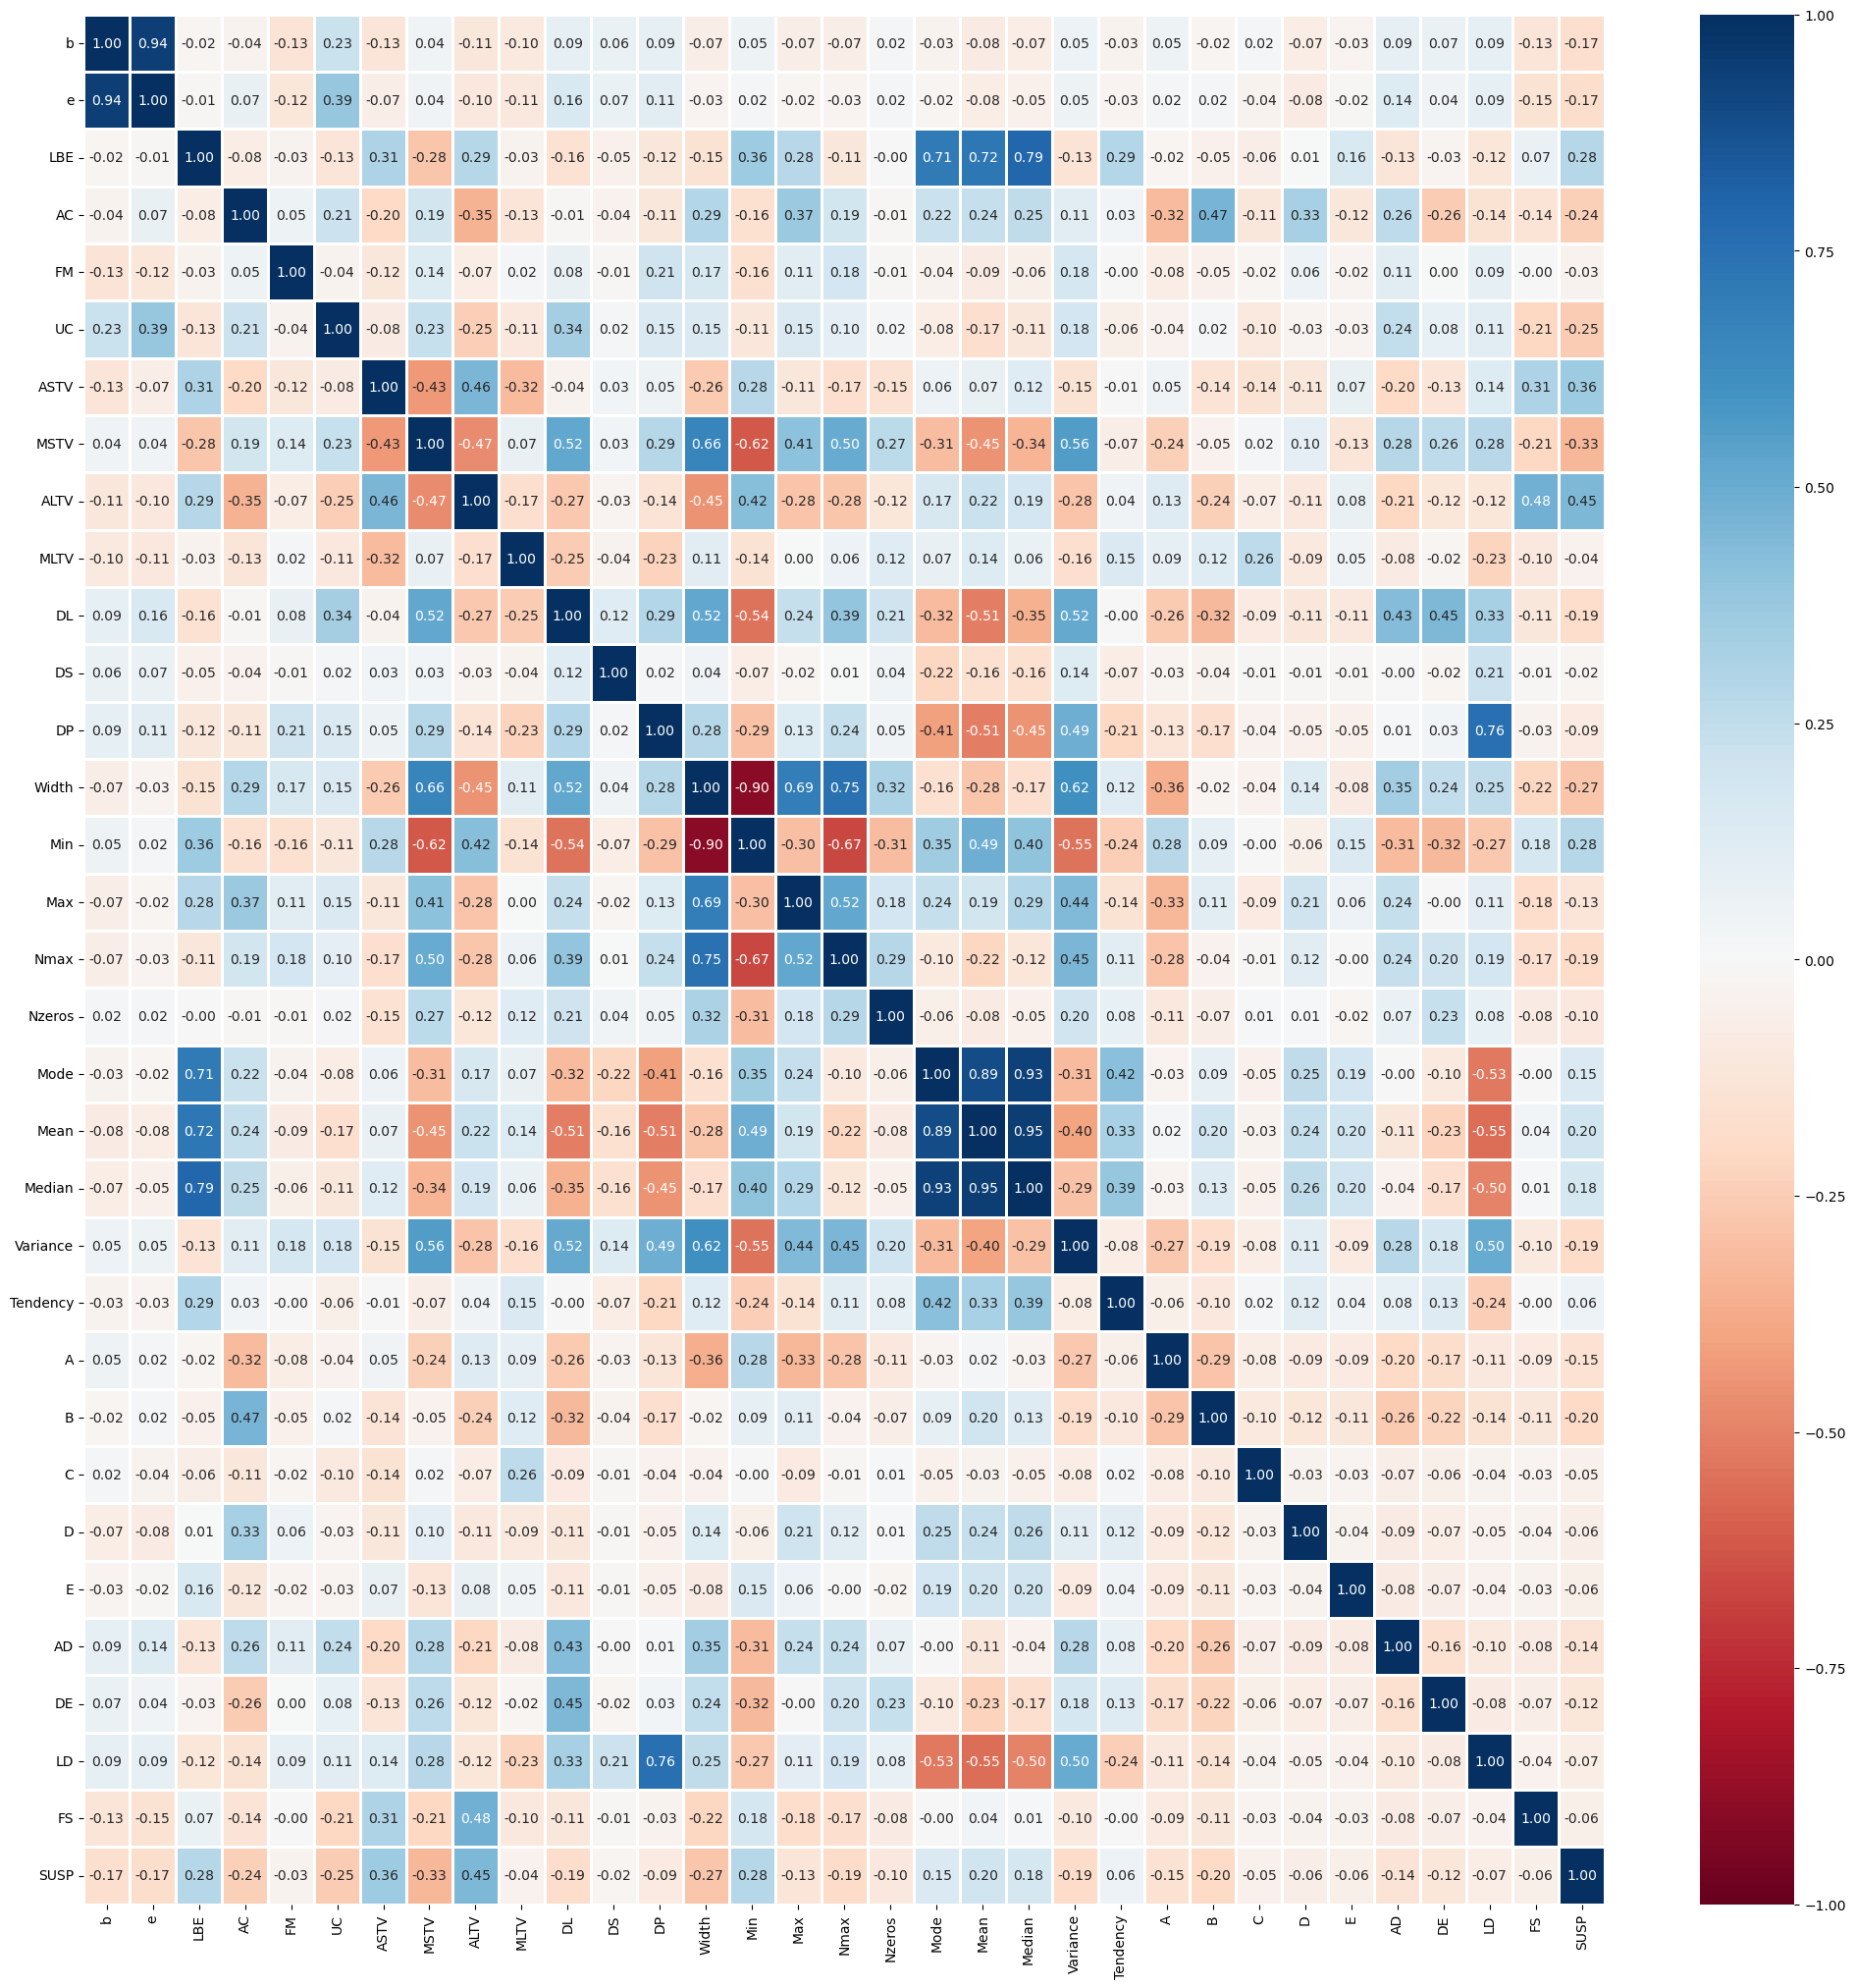

In [60]:
# Heatmap of the Correlation Matrix
f = plt.figure(figsize=(25, 25))
sb.heatmap(X_features.corr(), vmin = -1, vmax = 1, linewidths = 1,
           annot = True, fmt = ".2f", annot_kws = {"size": 10}, cmap = "RdBu")

#### Featured Data Type

In [61]:
print("=== Feature Type Analysis ===")

categorical_features = []
continuous_features = []
binary_features = []

for col in X_features.columns:
    unique_vals = sorted(X_features[col].unique())
    n_unique = len(unique_vals)
    
    # Categorize based on unique values
    if n_unique == 2 and set(unique_vals) == {0.0, 1.0}:
        binary_features.append(col)
    elif n_unique <= 5 and all(isinstance(x, (int, float)) and x == int(x) for x in unique_vals):
        categorical_features.append(col)
    elif n_unique > 20:
        continuous_features.append(col)

print(f"Binary features: {len(binary_features)}")
print(f"Categorical features: {len(categorical_features)}")  
print(f"Continuous features: {len(continuous_features)}")
print(f"Total features: {len(X_features.columns)}")

print(f"\nBinary features: {binary_features}")
print(f"Categorical features: {categorical_features}")
print(f"Continuous features: {continuous_features}")

=== Feature Type Analysis ===
Binary features: 11
Categorical features: 2
Continuous features: 16
Total features: 33

Binary features: ['DS', 'A', 'B', 'C', 'D', 'E', 'AD', 'DE', 'LD', 'FS', 'SUSP']
Categorical features: ['DP', 'Tendency']
Continuous features: ['b', 'e', 'LBE', 'AC', 'FM', 'ASTV', 'MSTV', 'ALTV', 'MLTV', 'Width', 'Min', 'Max', 'Mode', 'Mean', 'Median', 'Variance']


#### Descriptive Statistics of Features

In [62]:
# Analyze timing features vs target
stats_cols = [col for col in ['b', 'e'] if col in df_cleaned.columns]
timming_summary = df_cleaned.groupby(y_target)[stats_cols].agg(['median', 'mean', 'std']).round(2)
timming_summary

b                       e                 
    median    mean     std  median     mean     std
NSP                                                
1    651.0  952.83  915.02  1487.0  1781.98  942.99
2    233.0  481.96  656.53  1174.0  1299.37  733.51
3    494.0  843.44  866.54  1220.0  1635.35  936.20

In [63]:
# Analyze multicollinear features vs target
stats_cols = [col for col in ['Mode', 'Mean', 'Median'] if col in df_cleaned.columns]
multicollinear_summary = df_cleaned.groupby(y_target)[stats_cols].agg(['median', 'mean', 'std']).round(2)
multicollinear_summary

Mode                  Mean                Median               
    median    mean    std median    mean    std median    mean    std
NSP                                                                  
1    138.0  138.26  13.42  135.0  135.10  13.02  138.0  138.46  12.60
2    147.0  146.56  10.98  146.0  144.76  10.52  148.0  147.07  10.49
3    122.5  114.61  26.15  106.5  112.98  22.78  116.0  119.56  19.34

In [64]:
#Analyze binary features
stats_cols = [col for col in ['DS', 'AD', 'DE', 'LD', 'FS', 'SUSP'] if col in df_cleaned.columns]
binary_summary = df_cleaned.groupby(y_target)[stats_cols].agg(['median', 'mean', 'std']).round(2)
binary_summary

DS                 AD                 DE                 LD        \
    median  mean   std median  mean   std median  mean   std median  mean   
NSP                                                                         
1      0.0  0.00  0.02    0.0  0.20  0.40    0.0  0.14  0.34    0.0  0.00   
2      0.0  0.00  0.00    0.0  0.01  0.08    0.0  0.08  0.28    0.0  0.00   
3      0.0  0.03  0.18    0.0  0.00  0.00    0.0  0.00  0.00    1.0  0.61   

              FS               SUSP              
      std median  mean   std median  mean   std  
NSP                                              
1    0.00    0.0  0.00  0.00    0.0  0.00  0.00  
2    0.00    0.0  0.00  0.06    1.0  0.66  0.47  
3    0.49    0.0  0.39  0.49    0.0  0.01  0.08

#### Remove useless features
- `b`/`e` (low importance)
- `Mode`/`Median` (multicollinear)

In [65]:
columns_to_drop = ['b', 'e', 'Mode','Median']
X_features.drop(columns=columns_to_drop, inplace=True)

In [66]:
X_features.shape

(2126, 29)

In [67]:
X_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 29 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   LBE       2126 non-null   float64
 1   AC        2126 non-null   float64
 2   FM        2126 non-null   float64
 3   UC        2126 non-null   float64
 4   ASTV      2126 non-null   float64
 5   MSTV      2126 non-null   float64
 6   ALTV      2126 non-null   float64
 7   MLTV      2126 non-null   float64
 8   DL        2126 non-null   float64
 9   DS        2126 non-null   float64
 10  DP        2126 non-null   float64
 11  Width     2126 non-null   float64
 12  Min       2126 non-null   float64
 13  Max       2126 non-null   float64
 14  Nmax      2126 non-null   float64
 15  Nzeros    2126 non-null   float64
 16  Mean      2126 non-null   float64
 17  Variance  2126 non-null   float64
 18  Tendency  2126 non-null   float64
 19  A         2126 non-null   float64
 20  B         2126 non-null   floa

## Model training & SMOTE

We choose 4 models:

>**Logistic Regression** — A simple, honest baseline for CTG’s numeric data; if it does nearly as well as others, the classes are mostly separable with straight lines. Its probabilities are easy to tune for the rarer classes.

> **Random Forest**— Works well out-of-the-box on tabular data; it can capture feature interactions in CTG without much tuning and isn’t bothered by scaling or a few odd values.

> **XGBoost**— Often the top performer on structured datasets like CTG; it learns complex patterns and gives reliable probabilities once calibrated so we can push recall for important classes.

> **SVC (RBF kernel)**— Draws smooth, curved boundaries; great when CTG classes aren’t perfectly linear and with probabilities turned on we can still calibrate and set smart thresholds.

In [68]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Map NSP from 1,2,3 -> 0,1,2
to_zero_index = {1:0, 2:1, 3:2}
y_target = y_target.map(to_zero_index)

# Separate features and labels
X = X_features   # Features
y = y_target          # Target


# 1. Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 2. Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Apply SMOTE on the scaled training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print("Before SMOTE:", y_train.value_counts().to_dict())
print("After SMOTE:", y_train_resampled.value_counts().to_dict())


Before SMOTE: {0: 1323, 1: 236, 2: 141}
After SMOTE: {2: 1323, 0: 1323, 1: 1323}


#### Explanation of the Results:

**Before SMOTE:**

- Class 0 (Normal): 1323 samples

- Class 1 (Suspect): 236 samples

- Class 2 (Pathologic): 141 samples

This shows that the dataset is imbalanced, with Class 1 and Class 2 significantly underrepresented compared to Class 0.

**After SMOTE:**

- Class 0 (Normal): 1323 samples

- Class 1 (Suspect): 1323 samples

- Class 2 (Pathologic): 1323 samples

SMOTE has synthetically generated samples for Class 1 and Class 2 until each class has 1323 samples, making the dataset balanced.


**❓How SMOTE Works in This Case:**

After applying SMOTE, **all three classes have 1323 samples**, effectively balancing the dataset

In [75]:
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix,
                             f1_score, balanced_accuracy_score, make_scorer,
                             accuracy_score,precision_recall_curve,average_precision_score)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier


RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# ---------------- Models ----------------
models = {
    "LogReg": LogisticRegression(max_iter=3000),
    "RF":     RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1),
    "SVC":    SVC(kernel="rbf", probability=True, random_state=RANDOM_STATE),
    "XGB": XGBClassifier(objective="multi:softprob",
        eval_metric="mlogloss",
        tree_method="hist",
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
}

# ---------------- Search spaces ----------------
param_grids = {
    "LogReg": {
        "clf__C": [0.05, 0.1, 0.2, 0.5, 1, 2, 5],
        "clf__class_weight": [None, "balanced"],
        "smote__k_neighbors": [3, 5, 7],
    },
    "RF": {
        "clf__n_estimators": [300, 500, 800],
        "clf__max_depth": [None, 10, 20, 30],
        "clf__min_samples_split": [2, 5, 10],
        "clf__min_samples_leaf": [1, 2, 4],
        "smote__k_neighbors": [3, 5, 7],
    },
    "SVC": {
        "clf__C": [0.5, 1, 2, 5, 10],
        "clf__gamma": ["scale", 0.1, 0.05, 0.02],
        "smote__k_neighbors": [3, 5, 7],
    },
    "XGB": {
        "clf__n_estimators": [300, 600, 1000],
        "clf__max_depth": [3, 5, 7],
        "clf__learning_rate": [0.03, 0.06, 0.1],
        "clf__subsample": [0.7, 0.9, 1.0],
        "clf__colsample_bytree": [0.7, 0.9, 1.0],
        "clf__min_child_weight": [1, 3, 5],
        "smote__k_neighbors": [3, 5],
    }
}


# ---------------- Helpers ----------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scorer = make_scorer(f1_score, average="macro")

def make_pipe(clf):
    return Pipeline([
        ("scale", StandardScaler()),
        ("smote", SMOTE(random_state=RANDOM_STATE)),
        ("clf", clf)
    ])

def search_model(name, clf, param_grid, n_iter=20):
    pipe = make_pipe(clf)
    search = RandomizedSearchCV(
        pipe,
        param_distributions=param_grid,
        n_iter=n_iter,
        scoring=scorer,
        cv=cv,
        n_jobs=-1,
        refit=True,
        verbose=0,
        random_state=RANDOM_STATE
    )
    search.fit(X_train, y_train)
    return search.best_estimator_, search.best_score_, search.best_params_

# ---------------- Run all models ----------------
results = []  # list of dicts for nice printing/leaderboard
for name, clf in models.items():
    best_est, best_cv, best_params = search_model(name, clf, param_grids[name], n_iter=20)
    # Evaluate on test set
    y_pred = best_est.predict(X_test)
    test_f1_macro = f1_score(y_test, y_pred, average="macro")
    test_acc = accuracy_score(y_test, y_pred)
    test_bal_acc = balanced_accuracy_score(y_test, y_pred)

    # Store
    results.append({
        "model": name,
        "cv_f1_macro": best_cv,
        "test_f1_macro": test_f1_macro,
        "test_accuracy": test_acc,
        "test_bal_accuracy": test_bal_acc,
        "best_params": best_params,
        "estimator": best_est,  
    })

    # Print per-model summary
    print(f"\n=== {name} ===")
    print(f"CV F1-macro:      {best_cv:.4f}")
    print(f"Test F1-macro:    {test_f1_macro:.4f}")
    print(f"Test Accuracy:    {test_acc:.4f}")
    print(f"Test Bal. Acc.:   {test_bal_acc:.4f}")
    print("Best params:", best_params)

    # Detailed report/confusion matrix
    from sklearn.metrics import classification_report, confusion_matrix
    print("\nConfusion Matrix (labels [1,2,3]):")
    print(confusion_matrix(y_test, y_pred, labels=[0,1,2]))
    print("\nClassification Report (Test):")
    print(classification_report(y_test, y_pred, digits=4))

# ---------------- Leaderboard (by CV F1-macro) ----------------
results_sorted = sorted(results, key=lambda d: d["cv_f1_macro"], reverse=True)
print("\n\n=== Leaderboard (sorted by CV F1-macro) ===")
for r in results_sorted:
    print(f"{r['model']}: CV {r['cv_f1_macro']:.4f} | "
          f"Test F1-macro {r['test_f1_macro']:.4f} | "
          f"Acc {r['test_accuracy']:.4f} | BalAcc {r['test_bal_accuracy']:.4f}")


=== LogReg ===
CV F1-macro:      0.9830
Test F1-macro:    0.9779
Test Accuracy:    0.9859
Test Bal. Acc.:   0.9715
Best params: {'smote__k_neighbors': 5, 'clf__class_weight': None, 'clf__C': 1}

Confusion Matrix (labels [1,2,3]):
[[330   2   0]
 [  3  56   0]
 [  1   0  34]]

Classification Report (Test):
              precision    recall  f1-score   support

           0     0.9880    0.9940    0.9910       332
           1     0.9655    0.9492    0.9573        59
           2     1.0000    0.9714    0.9855        35

    accuracy                         0.9859       426
   macro avg     0.9845    0.9715    0.9779       426
weighted avg     0.9859    0.9859    0.9859       426


=== RF ===
CV F1-macro:      0.9869
Test F1-macro:    0.9828
Test Accuracy:    0.9883
Test Bal. Acc.:   0.9718
Best params: {'smote__k_neighbors': 3, 'clf__n_estimators': 300, 'clf__min_samples_split': 10, 'clf__min_samples_leaf': 1, 'clf__max_depth': 20}

Confusion Matrix (labels [1,2,3]):
[[332   0   0]
 [ 

Calibrate XGBoost model(winner) to catch every class 2 case

#### Explanation of the Results:

**1. Cross-Validation F1-macro (CV F1-macro):**

This metric represents the average F1-score across all classes (Normal, Suspect, Pathologic) during cross-validation, using the macro average. It treats all classes equally, regardless of their size. A higher value indicates better overall performance across all classes.

Best F1-macro on CV:

- XGB: 0.9878

- RF: 0.9869

- SVC: 0.9862

- LogReg: 0.9830

**Interpretation:** The **XGBoost model** achieved the **highest CV F1-macro score**, indicating that it performed the best in cross-validation. The other models also performed well, with Random Forest coming second and Logistic Regression coming last.

**2. Test F1-macro (Test F1-macro):**

This is the F1-score evaluated on the test set, again using the macro average. It’s a critical metric for imbalanced datasets since it combines both precision and recall, with a focus on the minority classes.

Best F1-macro on Test:

- XGB: 0.9795

- RF: 0.9828

- SVC: 0.9778

- LogReg: 0.9779

**Interpretation: Random Forest (RF)** performs the best on the test set in terms of **F1-macro score**. This indicates that while XGBoost had the highest cross-validation score, Random Forest had a slightly better performance on the test data in terms of the macro F1-score.

**3. Test Accuracy (Test Accuracy):**

This is the overall accuracy on the test set, representing the proportion of correctly classified instances among all predictions.

Best Test Accuracy:

RF: 0.9883

LogReg: 0.9859

SVC: 0.9859

XGB: 0.9859

**Interpretation: Random Forest (RF)** has the **highest test accuracy at 0.9883**, meaning it correctly classified a larger percentage of instances compared to the other models. XGBoost, SVC, and Logistic Regression all have the same accuracy of 0.9859, which is still very good.

**4. Test Balanced Accuracy (Test Bal. Acc.):**

Balanced accuracy calculates the average of the recall obtained on each class. It's particularly useful for imbalanced datasets because it gives equal weight to each class's recall, so it doesn't favor the majority class.

Best Test Balanced Accuracy:

- RF: 0.9718

- SVC: 0.9754

- LogReg: 0.9715

- XGB: 0.9707

**Interpretation: SVC** has the **highest balanced accuracy of 0.9754**, indicating that it balances the recall between the minority and majority classes best. Random Forest and Logistic Regression perform similarly, while XGBoost is slightly behind.

**5. Best Parameters (Best params):**

These are the best hyperparameters identified during the RandomizedSearchCV for each model.

- LogReg: {'smote__k_neighbors': 5, 'clf__class_weight': None, 'clf__C': 1}

- RF: {'smote__k_neighbors': 3, 'clf__n_estimators': 300, 'clf__min_samples_split': 10, 'clf__min_samples_leaf': 1, 'clf__max_depth': 20}

- SVC: {'smote__k_neighbors': 3, 'clf__gamma': 0.02, 'clf__C': 2}

- XGB: {'smote__k_neighbors': 3, 'clf__subsample': 0.9, 'clf__n_estimators': 300, 'clf__min_child_weight': 3, 'clf__max_depth': 7, 'clf__learning_rate': 0.03, 'clf__colsample_bytree': 0.9}

**Interpretation:** These are the optimal hyperparameters found for each model. For example, XGBoost performed best with a learning rate of 0.03, subsample of 0.9, and max_depth of 7, among others.

In [70]:
try:
    xgb_rec = next(r for r in results if r["model"] == "XGB")
    winner_name = "XGB"
    winner = xgb_rec["estimator"]            # fitted Pipeline (scale->SMOTE->XGB)
    winner_cv = xgb_rec["cv_f1_macro"]
except StopIteration:
    # If your `results` is a DICT: {"XGB": (estimator, cv_score)}:
    winner_name = "XGB"
    winner, winner_cv = results["XGB"]

print(f"Winner set to {winner_name} (CV F1-macro={winner_cv:.4f})")

Winner set to XGB (CV F1-macro=0.9878)


#### Calibration + Thresholding for Pathologic Cases Detection

**Goal:** to detect Pathologic cases as much as possible. 

We will:

1. keep the test set untouched,

2. compare no calibration, sigmoid, and isotonic calibration on a validation split from the training set,

3. for each calibrated model, re-tune the decision threshold for class 2 to maximize its F1 on validation,

4. pick the best calibration strategy and apply its threshold once on the test set.

In [76]:
from sklearn.calibration import CalibratedClassifierCV
# === setup ===
TARGET = 2

# carve validation from TRAIN ONLY
X_subtr, X_val, y_subtr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)

# helper: compute best F1 for class TARGET (retuning threshold each time)
def best_f1_for_class(model, X, y, target):
    classes = list(model.classes_)
    idx = classes.index(target)
    p = model.predict_proba(X)[:, idx]
    yb = (y == target).astype(int)
    prec, rec, thr = precision_recall_curve(yb, p)
    f1 = 2 * (prec * rec) / (prec + rec + 1e-12)
    if len(thr) == 0:
        return 0.0, 0.5
    i = int(np.nanargmax(f1[:-1]))
    return float(f1[:-1][i]), float(thr[i])

# helper: macro-F1 with argmax (no special threshold)
def macro_f1_argmax(model, X, y):
    yp = model.predict(X)
    return f1_score(y, yp, average="macro")

# candidates: None, sigmoid, isotonic
cands = {
    "none": winner.fit(X_subtr, y_subtr),
    "sigmoid": CalibratedClassifierCV(estimator=winner, method="sigmoid", cv=5).fit(X_subtr, y_subtr),
    "isotonic": CalibratedClassifierCV(estimator=winner, method="isotonic", cv=5).fit(X_subtr, y_subtr)
}

# evaluate each candidate on validation
report = {}
for name, mdl in cands.items():
    macro_f1 = macro_f1_argmax(mdl, X_val, y_val)
    f1_c2, t_c2 = best_f1_for_class(mdl, X_val, y_val, TARGET)
    # also check ranking quality for class 2 (AUPRC)
    classes = list(mdl.classes_)
    idx = classes.index(TARGET)
    ap_c2 = average_precision_score((y_val==TARGET).astype(int), mdl.predict_proba(X_val)[:, idx])
    report[name] = {"macro_f1_argmax": macro_f1, "f1_class2_best": f1_c2, "t_class2_best": t_c2, "auprc_class2": ap_c2}

print("Validation comparison:", report)

# === choose the calibration by the metric you care about ===
# Option A: prioritize class-2 detection
choice = max(report.items(), key=lambda kv: kv[1]["f1_class2_best"])[0]
# Option B (alternative): overall balance
# choice = max(report.items(), key=lambda kv: kv[1]["macro_f1_argmax"])[0]

cal = cands[choice]
t2 = report[choice]["t_class2_best"]
print(f"Selected calibration = {choice} | t2 (class-2) = {t2:.4f}")

Validation comparison: {'none': {'macro_f1_argmax': 0.9958611083474281, 'f1_class2_best': 0.9999999999995, 't_class2_best': 0.786039412021637, 'auprc_class2': 1.0}, 'sigmoid': {'macro_f1_argmax': 0.9958611083474281, 'f1_class2_best': 0.9999999999995, 't_class2_best': 0.8378161580603407, 'auprc_class2': 0.9999999999999999}, 'isotonic': {'macro_f1_argmax': 0.9958611083474281, 'f1_class2_best': 0.9999999999995, 't_class2_best': 0.9409512468836576, 'auprc_class2': 1.0}}
Selected calibration = none | t2 (class-2) = 0.7860


In [77]:
#Apply on test set
classes = list(cal.classes_)
idx2 = classes.index(TARGET)
proba_test = cal.predict_proba(X_test)

# default argmax
pred_argmax = np.array(classes)[proba_test.argmax(axis=1)]

# override: call class 2 where P(class2) >= t2
y_pred_thr = np.where(proba_test[:, idx2] >= t2, TARGET, pred_argmax)

print("\nConfusion Matrix (thresholded):")
print(confusion_matrix(y_test, y_pred_thr, labels=classes))
print("\nClassification Report (thresholded):")
print(classification_report(y_test, y_pred_thr, digits=4))

print("Test F1-macro:", f1_score(y_test, y_pred_thr, average="macro"))
print("Test Accuracy:", accuracy_score(y_test, y_pred_thr))
print("Test Balanced Acc:", balanced_accuracy_score(y_test, y_pred_thr))


Confusion Matrix (thresholded):
[[331   1   0]
 [  4  55   0]
 [  0   0  35]]

Classification Report (thresholded):
              precision    recall  f1-score   support

           0     0.9881    0.9970    0.9925       332
           1     0.9821    0.9322    0.9565        59
           2     1.0000    1.0000    1.0000        35

    accuracy                         0.9883       426
   macro avg     0.9901    0.9764    0.9830       426
weighted avg     0.9882    0.9883    0.9881       426

Test F1-macro: 0.983008495752124
Test Accuracy: 0.9882629107981221
Test Balanced Acc: 0.9763971138792457


We improved overall accuracy, macro-F1, and balanced accuracy. Calibration + targeted thresholding gave a modest but meaningful lift in overall metrics and guaranteed detection of pathologic case, which matches the task’s risk priorities.

#### Interpretation

**Normal (0)** – Precision 0.988, Recall 0.997
→ Of all predicted Normal, 98.8% were truly Normal; of all true Normal, 99.7% were found.
Errors: 1 Normal was flagged as Suspect.

**Suspect (1)** – Precision 0.982, Recall 0.932
→ Of all predicted Suspect, 98.2% were truly Suspect; of all true Suspect, 93.2% were found.
Errors: 4 Suspect cases were missed (classified as Normal).

**Pathological (2)** – Precision 1.000, Recall 1.000
→ Every Pathological case (35/35) was correctly detected, and there were no false negatives for Pathological. 


**Overall**

- Accuracy: 0.9883

- F1-macro: 0.9830 (good balance across classes)

- Balanced Accuracy: 0.9764

- The calibrated XGBoost with class-specific thresholding is very accurate overall and, crucially, does not miss any Pathological cases.


**Limitations**

Performance on Suspect is strong but not perfect; Clinical policy should prioritizes catching more Suspects, nudge the Suspect threshold lower to trade a little precision for higher recall.

### **Feature importance**

In [85]:
def get_inner_pipeline(model):
    """Return the pipeline from a CalibratedClassifierCV or the model itself."""
    if isinstance(model, CalibratedClassifierCV):
        return model.estimator  # sklearn >=1.3
    return model

# ---- use it ----
pipe = get_inner_pipeline(cal)
print("Pipeline steps:", list(pipe.named_steps.keys()))
xgb_model = pipe.named_steps["clf"]

Pipeline steps: ['scale', 'smote', 'clf']


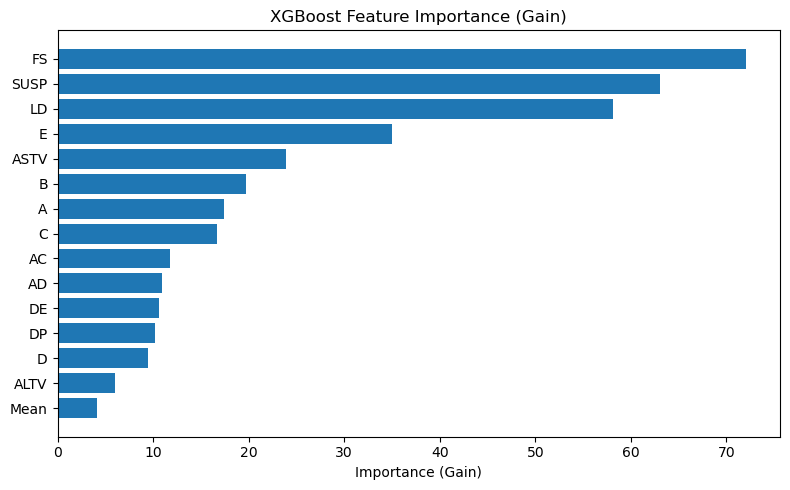

In [92]:
# keep the original feature names
orig_features = X_features.columns

# Get feature importances from XGB model
importances = xgb_model.get_booster().get_score(importance_type="gain")

# Map back to real column names
feat_imp = pd.DataFrame([
    {"Feature": orig_features[int(k[1:])], "Gain": v}
    for k, v in importances.items()
]).sort_values("Gain", ascending=False)

# Plot top 15
plt.figure(figsize=(8,5))
plt.barh(feat_imp["Feature"].head(15)[::-1], feat_imp["Gain"].head(15)[::-1])
plt.title("XGBoost Feature Importance (Gain)")
plt.xlabel("Importance (Gain)")
plt.tight_layout()
plt.show()

### 🔎 Feature Importance (XGBoost)

To understand how the model makes decisions, we looked at **feature importance** based on XGBoost (Gain metric).  

- **FS (Fetal State)** is the top feature, which makes sense because it directly reflects the clinical outcome class.  
- **SUSP (Suspicious pattern count)** and **LD (Long-Term Variability)** are also very important. Clinically, abnormal variability and suspicious CTG patterns are strong indicators of fetal distress.  
- **E (Accelerations)** and **ASTV (Short-Term Variability)** are key physiological markers: healthy fetuses usually show frequent accelerations and stable variability.  
- Other features like **histogram metrics (A, B, C)** and deceleration measures (**AC, AD, DE, DP**) contribute additional nuance.  
- Lower-ranked features (e.g., **ALTV, Mean FHR**) provide some signal but are less critical compared to variability and suspiciousness measures.  

✅ Overall, the model relies most on **variability, accelerations, and suspicious patterns** — the same markers doctors use in real CTG analysis. This shows the model is learning clinically meaningful patterns, not random noise.